In [1]:
import os
import sys
import numpy as np
import pickle

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
a = os.path.join(module_path, 'strands_qsr_lib', 'qsr_lib', 'src3')
print (a)
sys.path.append(a)

import project
# Need to add this import to load class
from project import Project
import config
import progress_learner
from rl import block_movement_env

/Users/tuando/git/learn-to-perform/strands_qsr_lib/qsr_lib/src3


In [2]:
from importlib import reload
reload(block_movement_env)

<module 'rl.block_movement_env' from '/Users/tuando/git/learn-to-perform/rl/block_movement_env.py'>

In [3]:
prefix = os.path.join( "..", "experiments", "human_evaluation_2d" )

In [4]:
feedback_files = {"SlideToward" : 'slideclose.txt', 
                  "SlideAway": 'slideaway.txt', 
                  "SlideNext": 'slidenext.txt', 
                  "SlidePast": 'slidepast.txt', 
                  "SlideAround": 'slidearound2.txt'}

In [5]:
def load_feedback_file( f ):
    """
    File format:
    
    0	6	8	2
    1	8	9	1
    2	8	7	1
    index	score_1	score2	disparity
    """
    scores = {}
    with open(f, 'r') as fh:
        for line in fh:
            values = [int(v) for v in line.split()]
            index = values[0]
            average_score = np.mean(values[1:3])
            
            scores[index] = average_score
    return scores

In [6]:
c = config.Config()

#### Loading projects from files

In [7]:
import tensorflow as tf

sess =  tf.Session()

In [8]:
projects = {}
progress_estimators = {}
configs = {}

action_types = ["SlideToward", "SlideAway", "SlideNext", "SlidePast", "SlideAround"]

for project_name in action_types:
    configs[project_name] = config.Config()
    if project_name == 'SlideNext':
        configs[project_name].n_input = 8
        
    print ('========================================================')
    print ('Load for action type = ' + project_name)
    p_name = project_name.lower() + "_project.proj"

    projects[project_name] = project.Project.load(os.path.join('..', 'learned_models', p_name))
    
    with tf.variable_scope("model") as scope:
        print('-------- Load progress model ---------')
        progress_estimators[project_name] = progress_learner.EventProgressEstimator(is_training=True, name = projects[project_name].name, config = configs[project_name])  

Load for action type = SlideToward
-------- Load progress model ---------
self.inputs.shape = (?, 20, 200)  after linear layer
output.shape = (30, 200) after LSTM
self.output.shape = (30,) after linear
self._targets.shape = (?,) 
Load for action type = SlideAway
-------- Load progress model ---------
self.inputs.shape = (?, 20, 200)  after linear layer
output.shape = (30, 200) after LSTM
self.output.shape = (30,) after linear
self._targets.shape = (?,) 
Load for action type = SlideNext
-------- Load progress model ---------
self.inputs.shape = (?, 20, 200)  after linear layer
output.shape = (30, 200) after LSTM
self.output.shape = (30,) after linear
self._targets.shape = (?,) 
Load for action type = SlidePast
-------- Load progress model ---------
self.inputs.shape = (?, 20, 200)  after linear layer
output.shape = (30, 200) after LSTM
self.output.shape = (30,) after linear
self._targets.shape = (?,) 
Load for action type = SlideAround
-------- Load progress model ---------
self.inputs.

In [9]:
for project_name in action_types:
    saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model/' + project_name))

    saver.restore(sess, os.path.join('..', 'learned_models', 'progress_' + project_name + '.mod'))

INFO:tensorflow:Restoring parameters from ../learned_models/progress_SlideToward.mod
INFO:tensorflow:Restoring parameters from ../learned_models/progress_SlideAway.mod
INFO:tensorflow:Restoring parameters from ../learned_models/progress_SlideNext.mod
INFO:tensorflow:Restoring parameters from ../learned_models/progress_SlidePast.mod
INFO:tensorflow:Restoring parameters from ../learned_models/progress_SlideAround.mod


In [10]:
## Function to load demonstrations
def load_data_from_folder ( folder, c, p, pe, sess ):
    """
    c: Config
    p: Project
    pe: Progress_estimator
    sess: Tensorflow session
    """
    demonstrations = {}
    for index in range(30):
        stored_config_file = os.path.join(folder, str(index) + ".dat")
        try:
            with open(stored_config_file, 'rb') as fh:
                # need this encoding 
                stored_config = pickle.load(fh, encoding='latin-1')

                e = block_movement_env.BlockMovementEnv(c, p.speed, p.name, 
                        progress_estimator = pe, session = sess)
                e.reset_env_to_state(stored_config['start_config'], stored_config['action_storage'])

                demonstrations[index] = e
        except IOError:
            pass
    return demonstrations

In [11]:
import automatic_evaluator
reload(automatic_evaluator)

<module 'automatic_evaluator' from '/Users/tuando/git/learn-to-perform/automatic_evaluator.py'>

In [12]:
def get_corref ( automatic_scores , graded_scores ):
    x = []
    y = []
    for k in automatic_scores:
        if k in graded_scores:
            x.append(automatic_scores[k])
            y.append(graded_scores[k])
    return np.corrcoef(x, y)[0,1]

In [13]:
def dos2unix (original, destination):
    with open(original, 'rb') as infile:
        content = infile.read()
    with open(destination, 'wb') as output:
        for line in content.splitlines():
            output.write(line + str.encode('\n'))

#### Test for Slide Closer To

Using the method **test_slide_close**, we have one hyperparameter to set:
threshold. By default, it is 2 * block_size

In [29]:
close_demos = load_data_from_folder(os.path.join(prefix, 'SlideClose'), configs['SlideToward'], 
                                    projects['SlideToward'], progress_estimators['SlideToward'], sess)

In [30]:
close_automatic_scores = dict((index, automatic_evaluator.test_slide_close(demo)) for index, demo in close_demos.items())


In [32]:
close_graded_scores = load_feedback_file ( os.path.join (prefix, feedback_files['SlideToward'] ) )

In [41]:
get_corref(close_automatic_scores, close_graded_scores)

0.29390650586323525

Grid search for the value of threshold

In [55]:
print (' & '.join(str(val) for val in np.linspace(1.5, 4.5, num=13)))
corefs = []
for threshold in np.linspace(1.5, 4.5, num=13):
    score  = dict((index, automatic_evaluator.test_slide_close(demo, threshold = threshold * c.block_size)) for index, demo in close_demos.items())
    coref = get_corref(score, close_graded_scores)
    corefs.append(coref)
    
print (' & '.join('%.2f' % val for val in corefs))

1.5 & 1.75 & 2.0 & 2.25 & 2.5 & 2.75 & 3.0 & 3.25 & 3.5 & 3.75 & 4.0 & 4.25 & 4.5
-0.09 & 0.17 & 0.29 & 0.11 & 0.18 & 0.22 & 0.22 & 0.34 & 0.40 & 0.39 & 0.39 & 0.39 & 0.34


#### Test for Slide Past

Using the method **test_slide_past**, we have one hyperparameter to set:
angle_threshold. We will run grid search for the value of angle_threshold / np.pi 

In [56]:
past_demos = load_data_from_folder(os.path.join(prefix, 'SlidePast'), configs['SlidePast'], 
                                    projects['SlidePast'], progress_estimators['SlidePast'], sess)

past_automatic_scores = dict((index, automatic_evaluator.test_slide_past(demo)) for index, demo in past_demos.items())

past_graded_scores = load_feedback_file ( os.path.join (prefix, feedback_files['SlidePast'] ) )

ValueError: shapes (1,2) and (1,2) not aligned: 2 (dim 1) != 1 (dim 0)

#### Test for Slide Away

Using the method **test_slide_away**, we have one hyperparameter to set:
ratio_threshold. We will run grid search for the value of ratio_threshold

In [61]:
away_demos = load_data_from_folder(os.path.join(prefix, 'SlideAway'), configs['SlideAway'], 
                                    projects['SlideAway'], progress_estimators['SlideAway'], sess)

In [60]:
away_automatic_scores = dict((index, automatic_evaluator.test_slide_away(demo)) for index, demo in away_demos.items())

away_graded_scores = load_feedback_file ( os.path.join (prefix, feedback_files['SlideAway'] ) )

In [62]:
get_corref(away_automatic_scores, away_graded_scores)

0.01411487319713608

In [80]:
print (' & '.join(str(val) for val in np.linspace(1.1, 2.8, num=18)))


1.1 & 1.2 & 1.3 & 1.4 & 1.5 & 1.6 & 1.7 & 1.8 & 1.9 & 2.0 & 2.1 & 2.2 & 2.3 & 2.4 & 2.5 & 2.6 & 2.7 & 2.8


In [79]:
corefs = []
for threshold in np.linspace(1.1, 2.8, num=18):
    score = dict((index, automatic_evaluator.test_slide_away(demo, 
      ratio_threshold = threshold)) for index, demo in away_demos.items())
    coref = get_corref(score, away_graded_scores)
    corefs.append(coref)
    
print (' & '.join('%.2f' % val for val in corefs))

-0.14 & -0.04 & 0.11 & 0.04 & 0.01 & 0.01 & 0.15 & 0.24 & 0.27 & 0.11 & 0.03 & 0.18 & 0.44 & 0.41 & 0.31 & 0.28 & 0.28 & 0.26


In [81]:
score = dict((index, automatic_evaluator.test_slide_away(demo, 
      ratio_threshold = 2.4)) for index, demo in away_demos.items())

#### Test for Slide Around

Using the method test_slide_around, we have two hyperparameters to set: *alpha_1, alpha_2*. These values are basically two arcs angles, with alpha_1 < alpha_2. 

In [14]:
# for index in range(30):
#     f = os.path.join(prefix, 'SlideAroundDiscrete', str(index) + ".dat")
    
#     dos2unix(f, f)

In [15]:
around_demos = load_data_from_folder(os.path.join(prefix, 'SlideAroundDiscrete'), configs['SlideAround'], 
                                    projects['SlideAround'], progress_estimators['SlideAround'], sess)

In [16]:
around_automatic_scores = dict((index, automatic_evaluator.test_slide_around(demo)) for index, demo in around_demos.items())

around_graded_scores = load_feedback_file ( os.path.join (prefix, feedback_files['SlideAround'] ) )

In [17]:
get_corref(around_automatic_scores, around_graded_scores)

0.26702442763770479

In [20]:
rs = np.linspace(0.7, 1.9, num = 7)

In [22]:
bitmap = np.zeros((7, 7))

In [23]:
for i, alpha_1 in enumerate(rs):
    for j, alpha_2 in enumerate(rs):
        if alpha_1 < alpha_2:
            scores = dict((index, automatic_evaluator.test_slide_around ( 
                demo, alpha_1 = alpha_1 * np.pi, alpha_2 = alpha_2 * np.pi )) 
                 for index, demo in around_demos.items())
            
            bitmap[i,j] = get_corref(scores, around_graded_scores)

In [25]:
bitmap

array([[ 0.        ,  0.32142211,  0.41171972,  0.49322772,  0.59127481,
         0.62692399,  0.46646036],
       [ 0.        ,  0.        ,  0.43408582,  0.51537989,  0.61192982,
         0.65225969,  0.51304036],
       [ 0.        ,  0.        ,  0.        ,  0.5394412 ,  0.63500862,
         0.68618767,  0.58726056],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.67039469,
         0.73274846,  0.66695003],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.80047419,  0.77266009],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.78119596],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]])

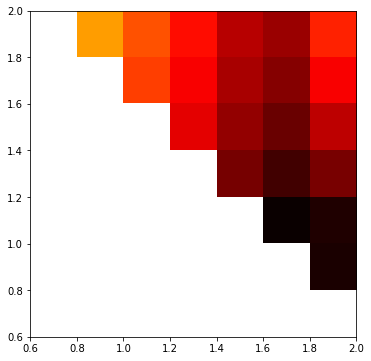

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(6,6))

ax.imshow(bitmap, cmap='hot_r', interpolation='nearest', 
          extent=[rs[0] - 0.1, rs[-1] + 0.1, rs[0] - 0.1, rs[-1] + 0.1])
# ax.set_xlim(rs[0], rs[-1])
# ax.set_xticks(rs)
# ax.set_ylim(rs[0], rs[-1])
# ax.set_yticks(rs)
plt.show()

#### Test for Slide Next To

Using the method test_slide_around, we have two hyperparameters to set: *alpha_1, alpha_2*. These values are basically two arcs angles, with alpha_1 < alpha_2. 